# Bonus: The `Cars Price` dataset revisited

🧑🏻‍🍳 During **`Machine Learning > 02 - Prepare the Dataset`**, we discovered that to run Machine Learning Algorithms properly, you need to feed them with ***cleaned datasets***.

<details>
    <summary>📝 <i>Reminders about the Data Preprocessing Workflow</i> 📝</summary>

1. 🧭 ***Exploratory Data Analysis***
2. 👥 Remove ***Duplicates***
3. 🤕 Impute or Remove ***Missing Values***
4. 🕵🏻‍♂️ Check for ***Outliers***
5. 📏 ***Scaling*** Numerical Features
6. 🏷 ***One-Hot-Encoder*** for Categorical Features 
7. 👻 ***Label-Encoder*** for a Categorical Target
8. 🍰 ***Feature Engineering*** will squeeze out better signals for your model to learn
feature instead_
9. 🍰 ***Target Engineering***: might be easier to predict a transformed target
    
10. ☠️ Not all features are our friends. Remove the "noisy" features using ***Feature Permutation*** (or ***VIF Analysis*** for Linear models)

<u> Additional Notes</u>    
    
- _Example of Feature Engineering: if you have the length and the width of a flat, you would maybe create the surface by multiplying the length by the width_

- _Example of Target Engineering: if you look to predict the price of a stock in the next day, it might be easier to predict the %increase rather than the absolute value. If you look at house prices, you may want to predict the logarithm of their values and then exponentiate the predictions_

- By "noisy" features, we mean :
    - either a feature that doesn't bring anything to the prediction in a sense that when you shuffle this feature, it doesn't affect the performance of your model
    - or a feature that is built using other features (strong linear relationship)
    
</details>

🚗 We had  already worked on a simplified version of the *Cars' Price* dataset. 

🎯 The goal of this recap is to build an optimal pipeline to ***predict the price of cars according to their specificities***:

1. We will need a *Preprocessing Pipeline*...
2. ... that we can *chain with a Scikit-Learn Estimator*
3. And go further by:
    - running a *FeaturePermutation*
    - optimizing the hyperparameters with a *GridSearchCV* or a *RandomizedSearchCV*

In [1]:
# DATA MANIPULATION
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",None) # Show all columns of a Pandas DataFrame

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# STATISTICS
from statsmodels.graphics.gofplots import qqplot
# This function plots your sample distribution against a Normal distribution, 
# to check whether your sample is normally distributed or not

# PIPELINE AND COLUMNTRANSFORMER
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.compose import TransformedTargetRegressor
from sklearn import set_config; set_config(display="diagram")  

# IMPUTERS
from sklearn.impute import SimpleImputer

# SCALERS
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

# ENCODER
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Func transformers
from sklearn.preprocessing import FunctionTransformer

# Models
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.svm import SVR

# Grid search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Construct custom transformer
# from sklearn.base import TransformerMixin, BaseEstimator

## (1) The dataset

In [2]:
cars = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/ML_cars_dataset_26_columns.csv")
cars.drop(columns = ['car_ID'], inplace = True)
cars.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
np.unique(cars.enginelocation, return_counts = True)

(array(['front', 'rear'], dtype=object), array([202,   3]))

### (1.1) Basic Info

❓ How many cars do we have ❓

In [4]:
# First make a copy of the cars df for the first steps
cars_copy = cars.copy()

In [5]:
# We will use the shape of the df
cars_copy.shape

(205, 25)

❓ Inspect the types of your columns ❓

In [6]:
# Use dtypes
cars_copy.dtypes

symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

### (1.2) Prerequisites

#### (1.2.1) Anomalies in the dataset

❓ If you carefully look at the columns with *object*, which columns could/should be converted to numerical columns  ❓ 

👉 Convert them.

<details>
    <summary><i>Hint</i></summary>

* The _cylindernumber_ clearly needs to be converted to a numerical feature
* As for the _doornumber_, it is up to you but we think that we can keep it as a categorical feature since most of the cars have either two or four doors, not one, three or five!
</details>


In [7]:
# We drop the useless columns
cars_copy = cars_copy.loc[:, ~cars_copy.columns.isin(['CarName'])]

# Have a look at the 'object' type columns
cat_columns = cars_copy.columns[cars_copy.dtypes == 'object']
display(cat_columns)

# Display the values (or the number of values) of each categorical feature
n_cat_values = cars_copy[cat_columns].nunique()
display(n_cat_values)

# Create an empty df to fill with encoded values
cars_copy_encoded = pd.DataFrame(index = cars_copy.index)

# Encode the categorical features : process by hand just for fun
for col in cat_columns:
    # Case if the number of features is inferior or equal to 2
    if n_cat_values[col] <= 2:
        # Instanciate an ordinal encoder
        ordinal_encoder = OrdinalEncoder()
        # Fit and transform and rewrite the original column
        cars_copy_encoded[col] = ordinal_encoder.fit_transform(cars_copy[[col]])
    
    else:
        # Instanciate a one hot encoder, don't forget not to return a sparse output
        ohe_encoder = OneHotEncoder(sparse_output = False)
        # Fit, transform and rewrite the original column, don't forget to unpack properly all the ohe columns with get_features_names_out
        cars_copy_encoded[ohe_encoder.get_feature_names_out().tolist()] = ohe_encoder.fit_transform(cars_copy[[col]])

# Create the cars copy with only numerical features
cars_copy_numerical = cars_copy.loc[:, ~cars_copy.columns.isin(cat_columns)]

# Merge the encoded df and the original df with just the numerical columns
cars_copy_processed = cars_copy_numerical.join(cars_copy_encoded, how = 'left')

# Show result
cars_copy_processed.head()

Index(['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel',
       'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem'],
      dtype='object')

fueltype          2
aspiration        2
doornumber        2
carbody           5
drivewheel        3
enginelocation    2
enginetype        7
cylindernumber    7
fuelsystem        8
dtype: int64

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,fueltype,aspiration,doornumber,carbody_convertible,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,drivewheel_4wd,drivewheel_fwd,drivewheel_rwd,enginelocation,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_eight,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,fuelsystem_1bbl,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi
0,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### (1.2.2) Removing duplicates 

❓ How many duplicated rows do we have in this dataset (if so, get rid of any duplicated row) ❓

In [8]:
# Use duplicated method then sum
display(cars_copy_processed.duplicated().sum())

# Drop duplicated values
cars_copy_processed.drop_duplicates(inplace = True)

# Check shape : May indicate an index problem when we join above !
cars_copy_processed.shape

1

(204, 49)

#### (1.2.3) Handling Missing Values

❓ How many NaN do we have ❓

In [9]:
# It was very smart to perform encoding before checking  for missing values
# So we will check for missing values for both the original and the copy processed of cars df

# Missing values for the original cars df
display(cars.isnull().sum())

# Missing values for the copy processed cars df
display(cars_copy_processed.isnull().sum())

# Test with the info method
cars.info()

symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

symboling                0
wheelbase                0
carlength                0
carwidth                 0
carheight                0
curbweight               0
enginesize               0
boreratio                0
stroke                   0
compressionratio         0
horsepower               0
peakrpm                  0
citympg                  0
highwaympg               0
price                    0
fueltype                 0
aspiration               0
doornumber               0
carbody_convertible      0
carbody_hardtop          0
carbody_hatchback        0
carbody_sedan            0
carbody_wagon            0
drivewheel_4wd           0
drivewheel_fwd           0
drivewheel_rwd           0
enginelocation           0
enginetype_dohc          0
enginetype_dohcv         0
enginetype_l             0
enginetype_ohc           0
enginetype_ohcf          0
enginetype_ohcv          0
enginetype_rotor         0
cylindernumber_eight     0
cylindernumber_five      0
cylindernumber_four      0
c

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

<details>
    <summary><i>Answer</i></summary>

* No NaN here, it's a miracle 😇 
* If you have more than 30% of missing values in a row/column, drop the row/column 🚮
* Otherwise, you could use a *SimpleImputer* or a *KNN Imputer* to impute these missing values 😉
    
</details>

Checking the category imbalance, very important :  
- The category imbalance may cause issues with the grid search cv, in particular with small datasets like this one
- Category imabalance may cause bad generalisation when cross validate

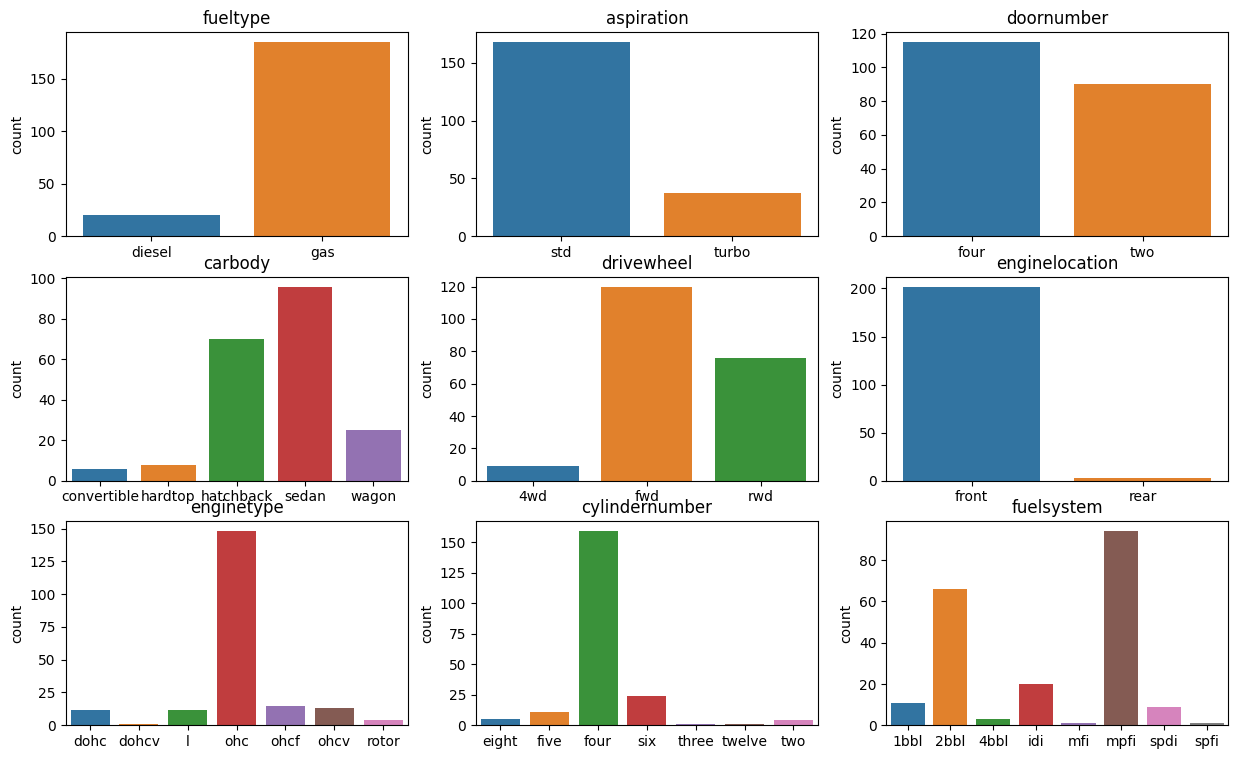

In [10]:
# Having a look at the category imbalance
# Select categorical columns
cars_cat = cars_copy.select_dtypes(include = 'object')

# Iterate over the cat columns to plot the class imbalance
# Number of columns of the plot
col_plots = 3
# Number of rows of the plot
rows_plot = cars_cat.shape[1] // col_plots

# Instanciate a plot
fig, ax = plt.subplots(rows_plot, col_plots, figsize = (15, col_plots * 15 * 0.2))

for i, col in enumerate(cars_cat.columns):
    # Unpack count of categories for each column
    cat_names, cat_count = np.unique(cars_cat[col], return_counts = True)
    # Transform into a df
    col_df = pd.DataFrame({'count': cat_count}, index = cat_names)
    # Subplot
    ax.flatten()[i].set_title(col)
    sns.barplot(data = col_df, x = col_df.index, y = 'count', ax = ax.flatten()[i])

# Show
plt.show()

### (1.3) Having a glance at your target (`cars' price`)

❓ How does your target look like in terms of _Distribution_, _Outliers_, _Gaussianity_  ❓

<details>
    <summary><i>Code answer</i></summary>

Save this block of code for future use ;)
```python
variable = 'price'
y = cars[f"{variable}"]

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].set_title(f"Distribution of the {variable}")
sns.histplot(data = cars, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot of the {variable}")
sns.boxplot(data = cars, x = f"{variable}", ax=ax[1])

ax[2].set_title(f"Gaussianity of:the {variable}")
qqplot(cars[f"{variable}"],line='s',ax=ax[2]);    
```
    
- The histogram with the estimated density shows us that ***the distribution of the prices is quite skewed and non-Gaussian***
- The boxplot indicates some potential outliers. You should check the values, and see, that these are just more expensive cars. But none of the values seems to be completely out of range, like a false measurement et cetera...! #BusinessKnowledge 
- The QQ-plot is another proof that the distribution of the prices is not Gaussian:
    - Remember that the scatter dots of your signal should match the $ y = x $ (45-degree line) closely, if the signal is Gaussian distributed.

</details>       

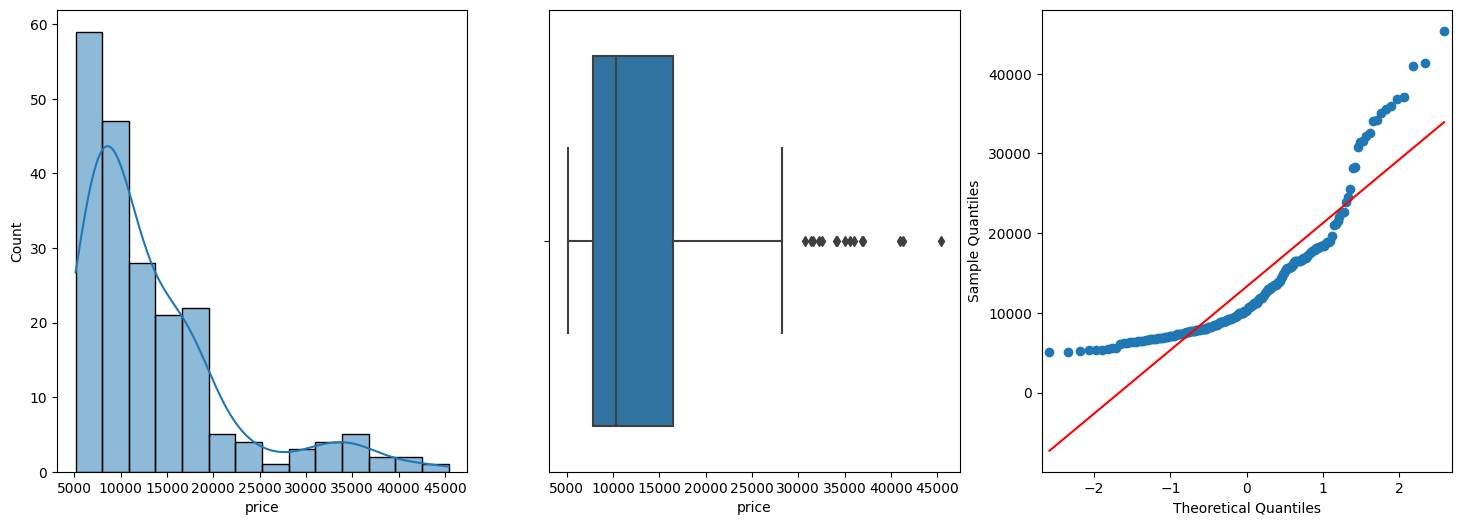

In [11]:
# Create the figure
fig, axs = plt.subplots(1, 3, figsize = (18, 6))

# Distribution of the target
sns.histplot(data = cars_copy_processed, x = 'price', kde = True, ax = axs[0])

# Outliers of the target
sns.boxplot(data = cars_copy_processed, x = 'price', ax = axs[1])

# Gaussianity of the target
qqplot(data = cars_copy_processed.price, line = 's', ax = axs[2])

# Show
plt.show()

In [12]:
numeric_columns = cars.select_dtypes(include=['number'])
numeric_columns.skew()

symboling           0.211072
wheelbase           1.050214
carlength           0.155954
carwidth            0.904003
carheight           0.063123
curbweight          0.681398
enginesize          1.947655
boreratio           0.020156
stroke             -0.689705
compressionratio    2.610862
horsepower          1.405310
peakrpm             0.075159
citympg             0.663704
highwaympg          0.539997
price               1.777678
dtype: float64

In [13]:
# The describe method is very usefull to show the quartiles, mean and median of all columns
numeric_columns.describe()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


## (2) Preprocessing the features with a Pipeline

🎬 Great, you have an overview of how the cars are distributed. 

🔥 It's time to build a _preprocessing pipeline_ that we will, in a humble way, call the _preprocessor_.

<details>
    <summary>🤔 How to deal with the <i>CarName</i> to predict the price of a car ? </summary>
    
1. You could extract the `CarBrand` using *Regex* techniques
2. As we haven't studied yet how to handle ***textual data*** (cf. ***Machine Learning > Natural Language Processing***), let's ignore the `CarName` to predict the price for the moment.
    
</details>

In [14]:
# Redefine X and y
# Copy cars and drop duplicate (if pandas wants it, we never now)
cars_copy = cars.copy()
cars_copy.drop_duplicates(inplace = True)

# Drop lines which cars has 'rear' engine location
cars_copy = cars_copy.loc[cars_copy.enginelocation != 'rear', :]

# Redefine X and y
X = cars_copy.drop(columns = ["price", "CarName"])
y = cars_copy[["price"]]

In [15]:
"""
Unfortunately, this class is useless, because it is impossible in sklearn to modify the names of columns inside the preprocessing pipeline, 
unless the .fit method of the model will be unable to parallelize the work.
"""

# class StatefullTranformer(TransformerMixin, BaseEstimator):
#     # BaseEstimator generates the get_params() and set_params() methods that all Pipelines require
#     # TransformerMixin creates the fit_transform() method from fit() and transform()

#     def __init__(self, func):
#         self.func = func

#     def fit(self, X: pd.DataFrame, y = None):
#         """Return the function apply to the dataframe"""
        
#         # Here you store what needs to be stored/learned during .fit(X_train) as instance attributes
#         # Return "self" to allow chaining .fit().transform()
        
#         return self.func(X)

#     def transform(self, X: pd.DataFrame, y = None):
#         """Return the function apply to the dataframe"""
        
#         # Return the result as a DataFrame for an integration into the ColumnTransformer
        
#         return self.func(X)
    
#     def fit_transform(self, X: pd.DataFrame, y = None):
#         """Return the function apply to the dataframe"""
        
#         return self.func(X)

'\nUnfortunately, this class is useless, because it is impossible in sklearn to modify the names of columns inside the preprocessing pipeline, \nunless the .fit method of the model will be unable to parallelize the work.\n'

### (2.1) Numerical Pipeline

❓ Store the numerical features in a `X_num` variable ❓

❓ Create a `num_transformer` pipeline to deal with numerical features ❓
<details>
    <summary>📚 <i>Reminder about scalers</i></summary>
    
👉 Great article <a href="https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02">Scale, Standardize or Normalize with Scikit-Learn</a> written by Jeff Hale    

</details>

In [16]:
"""
Unfortunately, this function is useless, because it is impossible in sklearn to modify the names of columns inside the preprocessing pipeline, 
unless the .fit method of the model will be unable to parallelize the work.
"""

# Define a function that take into input a df, and return a df with the name of column modify such as:
# Columns that present skewness greater that a threshold see their names modified
# def skewness_stamp(df: pd.DataFrame, th = 0.3) -> pd.DataFrame:
#     """
#     Define a function that take into input a df, and return a df with the name of column modify such as:
#     Columns that present skewness greater that a threshold see their names modified
#     The input datafram must be column numerical only
#     """
#     # Instanciate an empty mapper dict
#     mapper = dict()

#     # Select only numerical dtype columns
#     df = df.select_dtypes(include = 'number')
    
#     # Iterate over columns names
#     for col_name in df.columns:
        
#         # If the skewness of the column is superior to th
#         if abs(df[col_name].skew()) >= th:
#             mapper[col_name] = f"{col_name}_sk"
        
#         # Else
#         else:
#             mapper[col_name] = col_name
    
#     return df.rename(mapper = mapper, axis = 1)

# Test the function
# cars_num_test = skewness_stamp(cars)
# cars_num_test

'\nUnfortunately, this function is useless, because it is impossible in sklearn to modify the names of columns inside the preprocessing pipeline, \nunless the .fit method of the model will be unable to parallelize the work.\n'

In [17]:
"""I keep this code as archive"""

# Create the num transformer pipeline
# We should use a robust scaler because our numerical datas are skewed for most of them
# Second version with a robust and a standard scaler

# Select the right pipeline for the right column : column selector based on the skewness
# num_transformer_v2 = make_column_transformer((RobustScaler(), make_column_selector(pattern = r'\w+_sk\b')), 
#                                           (StandardScaler(), make_column_selector(pattern = r'\w+(?!_sk)\b'))
#                                           )

# Create a function transformer on the basis of the skewness stamp function
# skewness_stamp_transformer = StatefullTranformer(lambda df: skewness_stamp(df))

# Construct the num pipeline with the skewness stamp func
# num_pipeline = make_pipeline(skewness_stamp_transformer, num_transformer_v2)
# num_pipeline

'I keep this code as archive'

In [18]:
# Define a function that list all the column names such as the skewness of the column is inferior or equal, or superior to a number k
def skew_col_names(df: pd.DataFrame, k: float, sup_to_k: bool) -> list:
    """The function define a list of columns that respect a condition of skewness"""
    # Select only the numerical columns
    num_df = df.select_dtypes(include = 'number')
    
    # Make the columns filter
    col_filter = abs(num_df.skew()) > k
    
    # Return the list of columns which the skewness value is sup to k if sup_to_k is True, 
    # inf or equal to k else
    return num_df.columns[col_filter.values == sup_to_k].to_list()

# Test
skew_col_names(X, 0.3, False)

['symboling', 'carlength', 'carheight', 'boreratio', 'peakrpm']

In [19]:
# Working on the full cars df.
# Select the numerical features and store it into X num
X_num = X.select_dtypes(include = 'number')

# Select the right pipeline for the right column : column selector based on the skewness
num_transformer = make_column_transformer((RobustScaler(), skew_col_names(X_num, 0.3, True)), 
                                          (StandardScaler(), skew_col_names(X_num, 0.3, False))
                                          )

# Show
num_transformer

ColumnTransformer(transformers=[('robustscaler', RobustScaler(),
                                 ['wheelbase', 'carwidth', 'curbweight',
                                  'enginesize', 'stroke', 'compressionratio',
                                  'horsepower', 'citympg', 'highwaympg']),
                                ('standardscaler', StandardScaler(),
                                 ['symboling', 'carlength', 'carheight',
                                  'boreratio', 'peakrpm'])])

### (2.2) Categorical Pipeline

❓ Store the categorical features in a variable called `cars_cat` ❓

❓ Check how many columns you would end up with, if you decide to One Hot Encode them all. Is it a reasonable number ❓




In [20]:
# Nope !

❓ Create a `cat_transformer` pipeline to deal with categorical features ❓

In [21]:
"""
Unfortunately, this function is useless, because it is impossible in sklearn to modify the names of columns inside the preprocessing pipeline, 
unless the .fit method of the model will be unable to parallelize the work.
"""

# Create the cat num stamp function
# When the number of categories in a categorical column is superior to 2, apply a stamp at the end of the column name
# def cat_num_stamp(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Create the cat num stamp function
#     When the number of categories in a categorical column is superior to 2, apply a stamp at the end of the column name
#     The input df must be categorical columns only
#     """
#     # Instanciate an empty mapper dict
#     mapper = dict()
    
#     # Select only categorical dtype columns
#     df = df.select_dtypes(exclude = 'number')
    
#     # Iterate over the columns
#     for col_name in df.columns:
        
#         # If the number of categories exceed 2, stamp the column name with '_cat2'
#         if df[col_name].nunique() > 2:
#             mapper[col_name] = f"{col_name}_cat2"
        
#         # Else
#         else:
#             mapper[col_name] = col_name
    
#     return df.rename(mapper = mapper, axis = 1)

# Test the function
# cat_num_stamp(cars_cat)

'\nUnfortunately, this function is useless, because it is impossible in sklearn to modify the names of columns inside the preprocessing pipeline, \nunless the .fit method of the model will be unable to parallelize the work.\n'

In [22]:
"""I keep this code as archive"""

# Select the right pipeline for the right column : column selector based on the number of categories
# cat_transformer_v1 = make_column_transformer((OneHotEncoder(sparse_output = False), make_column_selector(pattern = r'\w+_cat2\b')), 
#                                              (OrdinalEncoder(), make_column_selector(pattern = r'\w+(?!_cat2)\b'))
#                                              )

# Construct a function transformer on the basis of the cat num stamp function
# cat_num_stamp_transformer = StatefullTranformer(lambda df: cat_num_stamp(df))

# Construct the num pipeline with the skewness stamp func
# cat_pipeline = make_pipeline(cat_num_stamp_transformer, cat_transformer_v1, MinMaxScaler())
# cat_pipeline

'I keep this code as archive'

In [23]:
# Define a function that list all the catgorical columns that contain less ore more than two categories
def cat_col_names(df: pd.DataFrame, sup_to_two: bool) -> list:
    """Return a list of columns that has less or more than two categories"""
    
    # Select only categorical columns
    cat_df = df.select_dtypes(exclude = 'number')
    
    # Make the column filter
    col_filter = cat_df.nunique() > 2
    
    # Return the list of columns which the cat value is sup to 2 if sup_to_two is True, 
    # inf or equal to 2 else
    return cat_df.columns[col_filter.values == sup_to_two].to_list()

# Test function
cat_col_names(X, True)

['carbody', 'drivewheel', 'enginetype', 'cylindernumber', 'fuelsystem']

In [31]:
# Working on the full cars df.
# Select the categorical features and store it into cars cat
cars_cat = X.select_dtypes(exclude = 'number')

# Select the right pipeline for the right column : column selector based on the number of categories
cat_transformer = make_column_transformer((OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), cat_col_names(cars_cat, True)), 
                                             (OrdinalEncoder(), cat_col_names(cars_cat, False))
                                             )

# Robust scale at the exit of the transformer
cat_transformer = make_pipeline(cat_transformer, RobustScaler())

# Show
cat_transformer

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['carbody', 'drivewheel',
                                                   'enginetype',
                                                   'cylindernumber',
                                                   'fuelsystem']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['fueltype', 'aspiration',
                                                   'doornumber',
                                                   'enginelocation'])])),
                ('robustscaler', RobustScaler())])

### (2.3) Full Preprocessor

❓ Create the `preprocessor` which combines the `num_transformer` and the `cat_transformer`  ❓

In [32]:
# Create the full pipeline with a column transformer
preprocessor = make_column_transformer((num_transformer, make_column_selector(dtype_include = np.number)), 
                                       (cat_transformer, make_column_selector(dtype_exclude = np.number))
                                       )

preprocessor

ColumnTransformer(transformers=[('columntransformer',
                                 ColumnTransformer(transformers=[('robustscaler',
                                                                  RobustScaler(),
                                                                  ['wheelbase',
                                                                   'carwidth',
                                                                   'curbweight',
                                                                   'enginesize',
                                                                   'stroke',
                                                                   'compressionratio',
                                                                   'horsepower',
                                                                   'citympg',
                                                                   'highwaympg']),
                                                                 ('standardscaler',
                                                                  StandardScaler(),
                                                                  ['symboling',
                                                                   'carlength',
                                                                   'carheight',
                                                                   'boreratio',
                                                                   'peakrpm'])]),
                                 <sklearn.compose._co...
                                                  ColumnTransformer(transformers=[('onehotencoder',
                                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                                 sparse_output=False),
                                                                                   ['carbody',
                                                                                    'drivewheel',
                                                                                    'enginetype',
                                                                                    'cylindernumber',
                                                                                    'fuelsystem']),
                                                                                  ('ordinalencoder',
                                                                                   OrdinalEncoder(),
                                                                                   ['fueltype',
                                                                                    'aspiration',
                                                                                    'doornumber',
                                                                                    'enginelocation'])])),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fb0e952cd60>)])

In [33]:
# Test the preproc pipeline on the full dataset
preprocessor.fit_transform(X).shape

(202, 48)

## (3) Full pipeline with a Regression Model

🚀 We can now try different regression model pipelined with the preprocessor 🚀

❓ Create a function that will create a Pipeline with the `preprocessor` and a regression model ❓

In [34]:
# Create the full pipeline with the model of my choice !
full_pipeline = make_pipeline(preprocessor, ElasticNet())
full_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('columntransformer',
                                                  ColumnTransformer(transformers=[('robustscaler',
                                                                                   RobustScaler(),
                                                                                   ['wheelbase',
                                                                                    'carwidth',
                                                                                    'curbweight',
                                                                                    'enginesize',
                                                                                    'stroke',
                                                                                    'compressionratio',
                                                                                    'horsepower',
                                                                                    'citympg',
                                                                                    'highwaympg']),
                                                                                  ('standardscaler',
                                                                                   StandardScaler(),
                                                                                   ['symboling',
                                                                                    'carlength',
                                                                                    'carheight',
                                                                                    'borerati...
                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                  sparse_output=False),
                                                                                                    ['carbody',
                                                                                                     'drivewheel',
                                                                                                     'enginetype',
                                                                                                     'cylindernumber',
                                                                                                     'fuelsystem']),
                                                                                                   ('ordinalencoder',
                                                                                                    OrdinalEncoder(),
                                                                                                    ['fueltype',
                                                                                                     'aspiration',
                                                                                                     'doornumber',
                                                                                                     'enginelocation'])])),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fb0e952cd60>)])),
                ('elasticnet', ElasticNet())])

In [35]:
# Construct the target regressor
regr = TransformedTargetRegressor(regressor = full_pipeline, transformer = RobustScaler())
regr

TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(transformers=[('columntransformer',
                                                                                       ColumnTransformer(transformers=[('robustscaler',
                                                                                                                        RobustScaler(),
                                                                                                                        ['wheelbase',
                                                                                                                         'carwidth',
                                                                                                                         'curbweight',
                                                                                                                         'enginesize',
                                                                                                                         'stroke',
                                                                                                                         'compressionratio',
                                                                                                                         'horsepower',
                                                                                                                         'citympg',
                                                                                                                         'highwaympg']),
                                                                                                                       ('standardscaler',
                                                                                                                        StandardScaler(),
                                                                                                                        ['symboli...
                                                                                                                                                       sparse_output=False),
                                                                                                                                         ['carbody',
                                                                                                                                          'drivewheel',
                                                                                                                                          'enginetype',
                                                                                                                                          'cylindernumber',
                                                                                                                                          'fuelsystem']),
                                                                                                                                        ('ordinalencoder',
                                                                                                                                         OrdinalEncoder(),
                                                                                                                                         ['fueltype',
                                                                                                                                          'aspiration',
                                                                                                                                          'doornumber',
                                                                                                                                          'enginelocation'])])),
                                                              

❓ Testing different pipelined regression models ❓


🤓 Do not forget to refer to [Scikit-Learn - Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html).

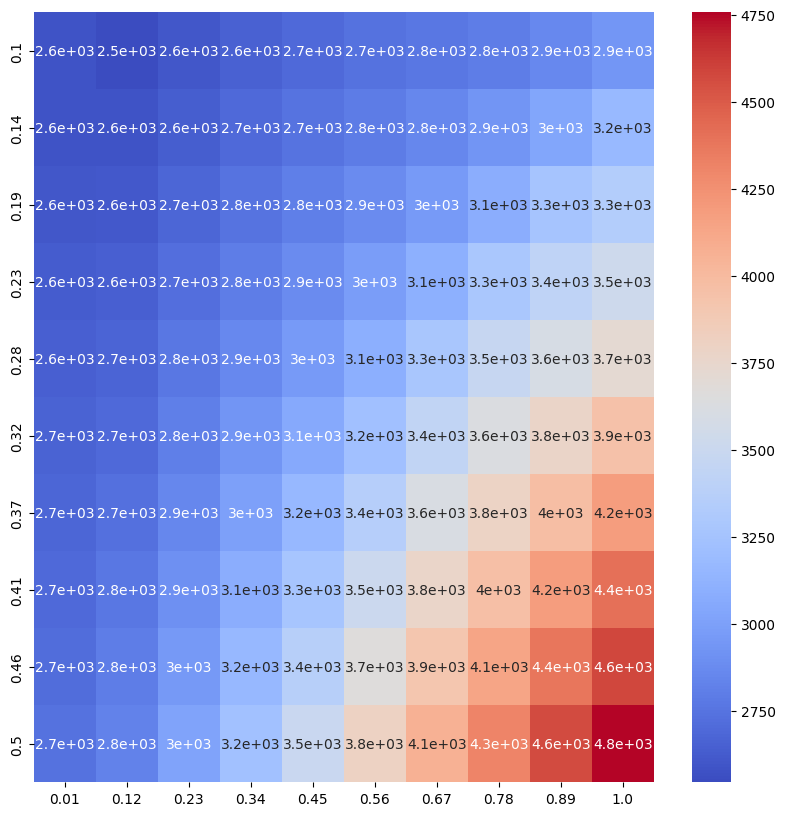

In [38]:
# Create the param grid
grid = {'regressor__elasticnet__alpha': np.linspace(0.1, 0.5, 10), # Be very careful with the key name in the grid, it may cause unexpected errors inside GridSearchcv !!!
        'regressor__elasticnet__l1_ratio': np.linspace(0.01, 1, 10)
        }

# Create the scoring dict
scoring_dict = {'neg_rmse': 'neg_root_mean_squared_error', 
                'neg_mae': 'neg_mean_absolute_error'}

# Create the grid search cv
grid_search = GridSearchCV(regr, 
                           param_grid = grid, 
                           scoring = scoring_dict, 
                           refit = 'neg_mae', 
                           cv = 5, 
                           n_jobs = -1)

# Fit
grid_search.fit(X, y)

# Results
mean_test_score = grid_search.cv_results_['mean_test_neg_mae']

# Reshape the results
mean_test_score = mean_test_score.reshape((10, 10))

# Plot the results
plt.figure(figsize = (10, 10))
sns.heatmap(
    abs(mean_test_score), # Re-convert into absolute value
    cmap = 'coolwarm', 
    annot = True, 
    yticklabels = np.round(grid['regressor__elasticnet__alpha'], 2), 
    xticklabels = np.round(grid['regressor__elasticnet__l1_ratio'], 2)
    )
plt.show()

❓ Evaluating the pipelined models: which pipelined regressor performed the best ❓

In [30]:
# YOUR CODE HERE
from scipy.stats import uniform

🏁 Congratulations!

💾 Don't forget to git add/commit/push your notebook...

🚀 You are now a master at `Pipeline` and `ColumnTransformer` !